In [1]:
import os
os.chdir("/home/mateusz/Dokumenty/AGH/inz/adversarial-robustness-toolbox/")

In [2]:
import os 
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import logging
from PIL import Image
from art.attacks.evasion.laser_attack.laser_attack import \
    LaserBeamAttack, LaserBeam, LaserBeamGenerator, ImageGenerator
from art.attacks.evasion.laser_attack.utils import add_images

In [3]:
from art.attacks.evasion.laser_attack.utils import \
    show_NRGB_image, ImageGenerator

In [4]:
min_lb = LaserBeam.from_array([380, 0, 0, 0])
max_lb = LaserBeam.from_array([780, 3.14, 32, 32])
lb_gen = LaserBeamGenerator(min_lb, max_lb, 0.2)

In [5]:
img_gen = ImageGenerator()

In [6]:
generated_img = img_gen.generate_image(lb_gen.random(), (32,32,3))

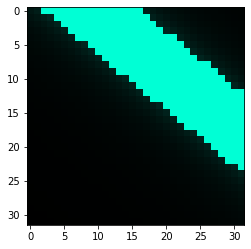

In [7]:
show_NRGB_image(generated_img)

### Constants

In [8]:
CLASSES = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
}

In [9]:
IMAGE_SIZE = (32, 32)
IMAGE_SHAPE = (*IMAGE_SIZE, 3)
REAL_CLASS = 1

In [10]:
CLASSES[REAL_CLASS]

'Speed limit (30km/h)'

### Helper functions

In [11]:
def rescale_image(image: np.ndarray, desired_size=IMAGE_SIZE):
	image_uin8 = (image*255).astype(np.uint8)
	img = Image.fromarray(image_uin8).resize(IMAGE_SIZE)
	return np.array(img)/255

In [12]:
def load_image(seeken_class):
	dir_path = f"../Models/gtsrb-german-traffic-sign/train/{seeken_class}"
	file_name = os.listdir(dir_path)[0]
	return  mimg.imread(f"{dir_path}/{file_name}")

In [13]:
def predict_image_class(image, model):
	image_expanded = np.expand_dims(image, 0)
	return model.predict(image_expanded)
	

In [14]:
def plot_results(
	real_image_and_class, 
	adversarial_image_and_class, 
	figsize=IMAGE_SIZE, 
	classes=CLASSES
):
	figure = plt.figure(figsize=figsize)
	for i, record in enumerate(
		[
			(*real_image_and_class, "Real"), 
			(*adversarial_image_and_class, "Adversarial"),
			(rescale_image(load_image(adversarial_image_and_class[1])), adversarial_image_and_class[1], "Confused with:")
		]
	):
		image, image_class_number, title = record
		image_class = classes[image_class_number]
		figure.add_subplot(1,3, i+1)
		plt.imshow(image)
		plt.title(title, fontsize=32)
		plt.xlabel(image_class, fontsize=32)
	plt.show()


In [15]:
model = tf.keras.models.load_model("../sandbox/sign_model2")

In [16]:
max_30_raw = mimg.imread( '../Models/gtsrb-german-traffic-sign/Test/00001.png')

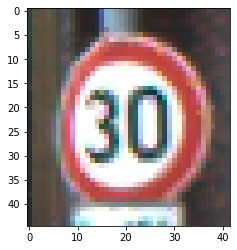

In [17]:
plt.imshow(max_30_raw)

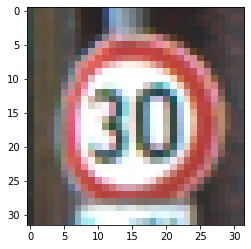

In [18]:
max_30 = rescale_image(max_30_raw)
plt.imshow(max_30)

In [19]:

max_30.shape

(32, 32, 3)

In [20]:
prediction = predict_image_class(max_30, model)

In [21]:
predicted_class = prediction.argmax()

In [22]:
CLASSES[predicted_class]

'Speed limit (30km/h)'

In [23]:
predicted_class == REAL_CLASS

True

## Time to attack

In [24]:
min_params = LaserBeam.from_numpy(np.array([380, 0, 0, 0]))
max_params = LaserBeam.from_numpy(np.array([780, 3.14, 32,32]))

laser_generator = LaserBeamGenerator(
    min_params, 
    max_params, 
    max_step=0.2
)

In [25]:
lb = laser_generator.random()

In [26]:
laser_generator.update_params(lb, sign=-1)

LaserBeam(wavelength=409.4322560252996, Line=Line(r=0.23104320979860166, b=0.0), width=0.0)

In [35]:
attack = LaserBeamAttack(
    estimator=model, 
    iterations=30,
    max_laser_beam=(780, 3.14, 32, 32)
)

In [36]:
laser_params, adversarial_class = attack.generate_parameters(
	image=np.expand_dims(max_30, axis=0), 
	actual_prediction=(predicted_class, prediction[0][predicted_class]) 
)

In [37]:
CLASSES[adversarial_class]

'End of speed limit (80km/h)'

In [38]:
adversarial_class == REAL_CLASS

False

In [39]:
laser_params

LaserBeam(wavelength=655.5936590722868, Line=Line(r=2.769030128929245, b=25.100852153243167), width=24.366487891136515)

In [40]:
adversarial_laser_image = ImageGenerator().generate_image(laser_params, shape=IMAGE_SHAPE)

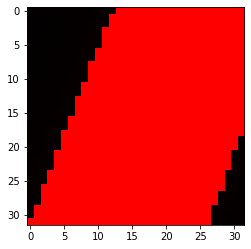

In [41]:
plt.imshow(adversarial_laser_image)

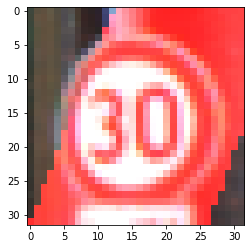

In [42]:
adversarial_image = add_images(max_30, adversarial_laser_image)
plt.imshow(adversarial_image)

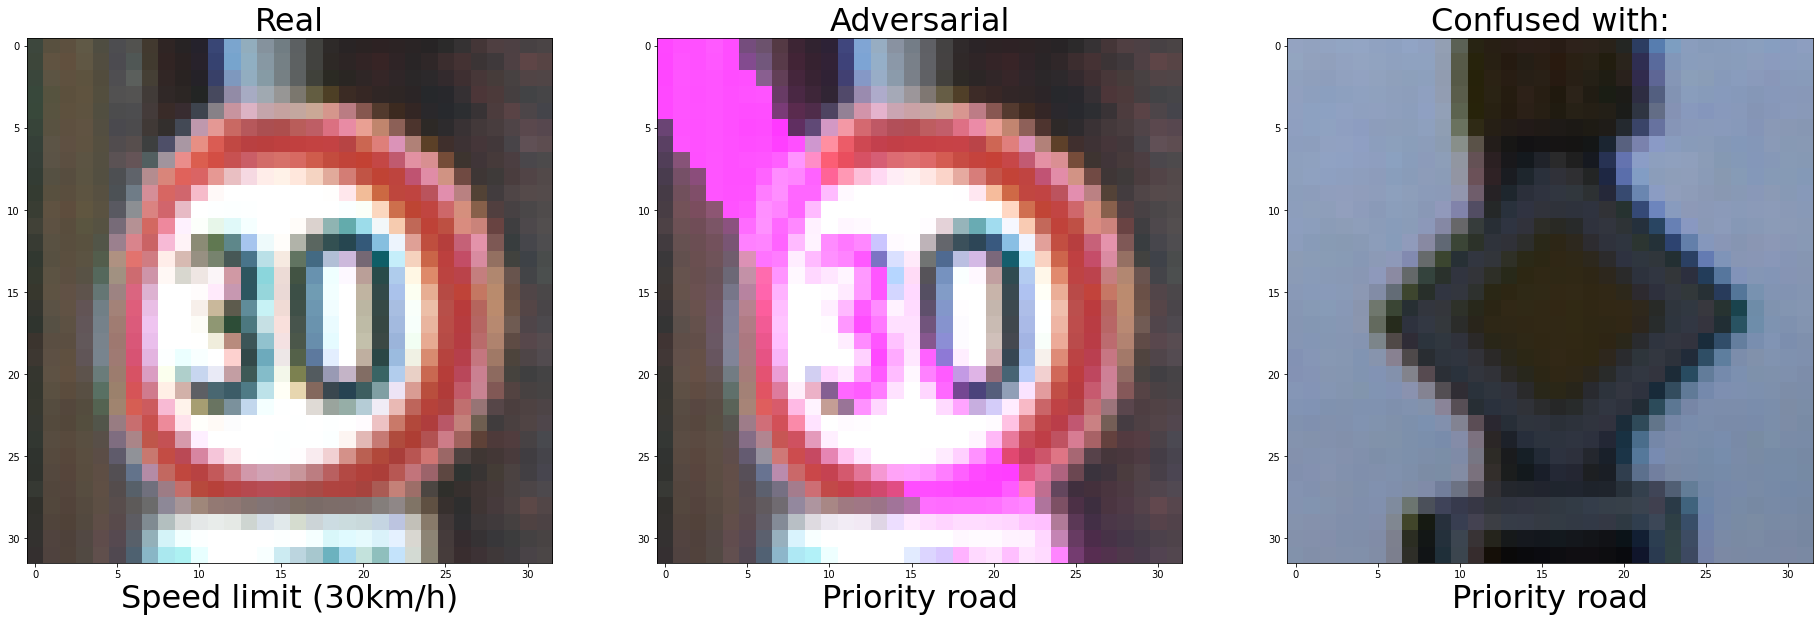

In [38]:
plot_results(
	(max_30, predicted_class),
	(adversarial_image, adversarial_class)
)

## External image

In [39]:
external_image_url = "https://thumbs.dreamstime.com/t/road-signs-main-road-sign-blue-background-road-signs-main-road-sign-blue-background-109436823.jpg"
r = requests.get(external_image_url, stream=True)

In [40]:
external_image_raw = np.array(Image.open(r.raw).convert("RGB"))/255

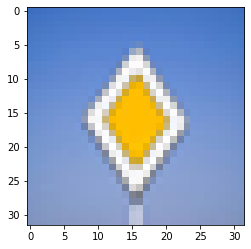

In [41]:
external_image = rescale_image(external_image_raw, IMAGE_SIZE)
plt.imshow(external_image)

In [42]:
external_image_prediction = predict_image_class(external_image, model)
external_image_class = external_image_prediction.argmax()

In [43]:
CLASSES[external_image_class]

'Speed limit (70km/h)'

In [44]:
np.expand_dims(external_image, 0).shape

(1, 32, 32, 3)

In [45]:
laser_params_ext, adversarial_class_ext = attack.generate(
	image=np.expand_dims(external_image, 0), 
	iterations=5,
	random_initializations=5
)

IndexError: tuple index out of range

In [ ]:
adv_image_ext = add_images(external_image, generate_laser_image(laser_params_ext, shape=IMAGE_SHAPE))

In [ ]:
plot_results(
	(external_image, CLASSES[external_image_class]),
	(adv_image_ext, CLASSES[adversarial_class_ext])
)